In [36]:

import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/')
from asapp.model import _dcpmf,_pmf
import pandas as pd
import numpy as np
np.random.seed(42)

from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pylab as plt
import seaborn as sns

import pytest
from numpy.testing import assert_allclose

np.random.seed(42)

def generate_data(N,K,M,mode):    

    if mode=='b':    
        from asapp.data import _sim 
        H = _sim.generate_H(N, K)
        W = _sim.generate_W(M, K)
        X = stats.poisson.rvs(H.dot(W.T))

    else:
        H = stats.gamma.rvs(0.5, scale=0.1, size=(N,K))
        W = stats.gamma.rvs(0.5, scale=0.1, size=(M,K))
        X = stats.poisson.rvs(H.dot(W.T))

    return H,W,X

def mpmf(X,K,max_iter):
    pmf = _pmf.PoissonMF(n_components=K,max_iter=max_iter,verbose=False)
    pmf.fit(X)
    return pmf

def mdcpmf(X,K,max_iter):
    pmf = _dcpmf.DCPoissonMF(n_components=K,max_iter=max_iter,verbose=False)
    pmf.fit(X)
    return pmf

def mdcpmf_batch(X,K,max_iter,n_pass):
    pmf = _dcpmf.DCPoissonMFSVB(n_components=K,max_iter=max_iter,n_pass=n_pass,verbose=False)
    pmf.fit(X)
    pmf.predict_theta(X)
    return pmf

def mdcpmf_membatch(X,K,max_iter,n_pass):
    pmf = _dcpmf.DCPoissonMFMVB(n_components=K,max_iter=max_iter,n_pass=n_pass,verbose=False)
    pmf.fit(X)
    pmf.predict_theta(X)
    return pmf

def test_dcpmf(d):

    N=100
    K=5
    M=200
    max_iter = 200
    n_pass = 200

    H,W,X = generate_data(N,K,M,mode=d)

    pmf = mpmf(X,K,max_iter)
    dcpmf = mdcpmf(X,K,max_iter)
    dcpmfb = mdcpmf_batch(X,K,max_iter,n_pass)
    dcpmfmb = mdcpmf_membatch(X,K,max_iter,n_pass)

    # assert_allclose(H,pmf.Etheta,rtol=1e-4)

    print('pmf-->')
    print("MSE W:", mse(W, pmf.Eb.T))
    print("MSE H:", mse(H, pmf.Et))

    print('all-->')
    print("MSE W:", mse(W, dcpmf.Ebeta.T))
    print("MSE H:", mse(H, dcpmf.Etheta))

    print('batch-online-->')
    print("MSE W:", mse(W, dcpmfb.Ebeta.T))
    print("MSE H:", mse(H, dcpmfb.Etheta))

    print('batch-mem-->')
    print("MSE W:", mse(W, dcpmfmb.Ebeta.T))
    print("MSE H:", mse(H, dcpmfmb.Etheta))

    return H,W,pmf,dcpmf,dcpmfb,dcpmfmb


In [37]:
H,W,pmf,dcpmf,dcpmfb,dcpmfmb = test_dcpmf('b')

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_pmf.py:148: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:59: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:197: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:179: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


pmf-->
MSE W: 132.0927832951105
MSE H: 44.83200940968711
all-->
MSE W: 142.3993167578439
MSE H: 2.0550883606334267
batch-online-->
MSE W: 124.1106850879155
MSE H: 1.961803478281137
batch-mem-->
MSE W: 127.46660218731532
MSE H: 1.9060943719756664


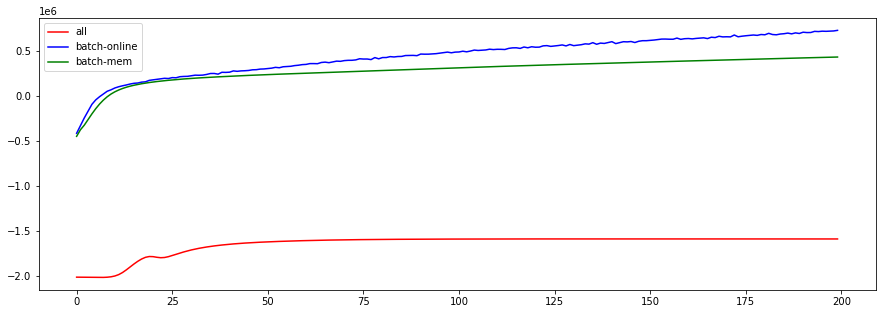

In [39]:
plt.plot(dcpmf.bound,'r',label='all')
plt.plot(dcpmfb.bound,'b',label='batch-online')
plt.plot(dcpmfmb.bound,'g',label='batch-mem')
plt.legend()


<AxesSubplot:ylabel='Density'>

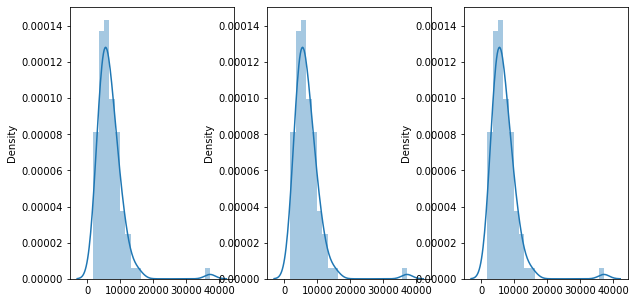

In [40]:
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
fig,axs = plt.subplots(1,3)
sns.distplot(dcpmf.ED,ax=axs[0])
sns.distplot(dcpmfb.ED,ax=axs[1])
sns.distplot(dcpmfmb.ED,ax=axs[2])

<AxesSubplot:ylabel='Density'>

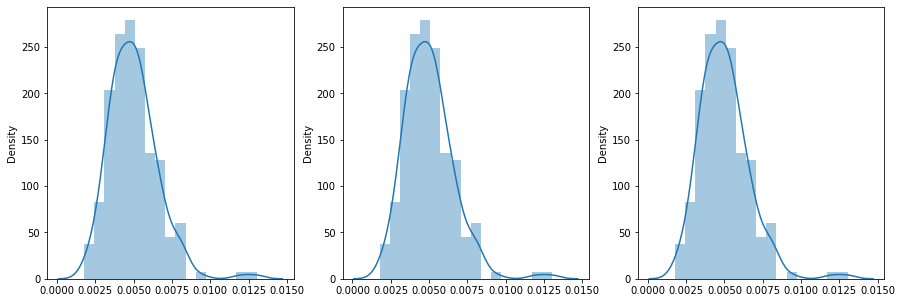

In [45]:
fig,axs = plt.subplots(1,3)
sns.distplot(dcpmf.EF,ax=axs[0])
sns.distplot(dcpmfb.EF,ax=axs[1])
sns.distplot(dcpmfmb.EF,ax=axs[2])

<AxesSubplot:>

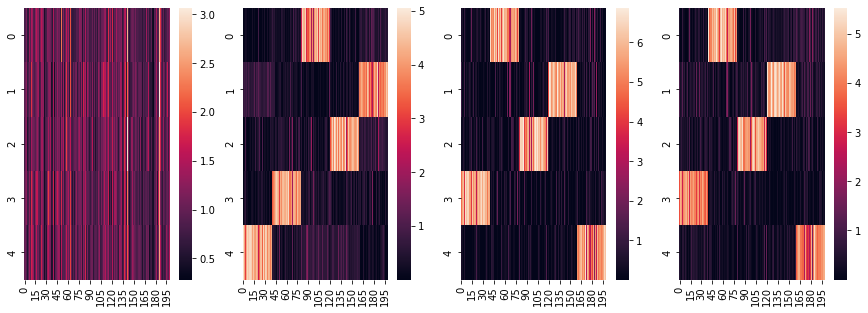

In [41]:
plt.rcParams["figure.figsize"] = (15,5)
fig,axs = plt.subplots(1,4)
sns.heatmap(pmf.Eb,ax=axs[0])
sns.heatmap(dcpmf.Ebeta,ax=axs[1])
sns.heatmap(dcpmfb.Ebeta,ax=axs[2])
sns.heatmap(dcpmfmb.Ebeta,ax=axs[3])

Text(218.45454545454544, 0.5, 'bulk')

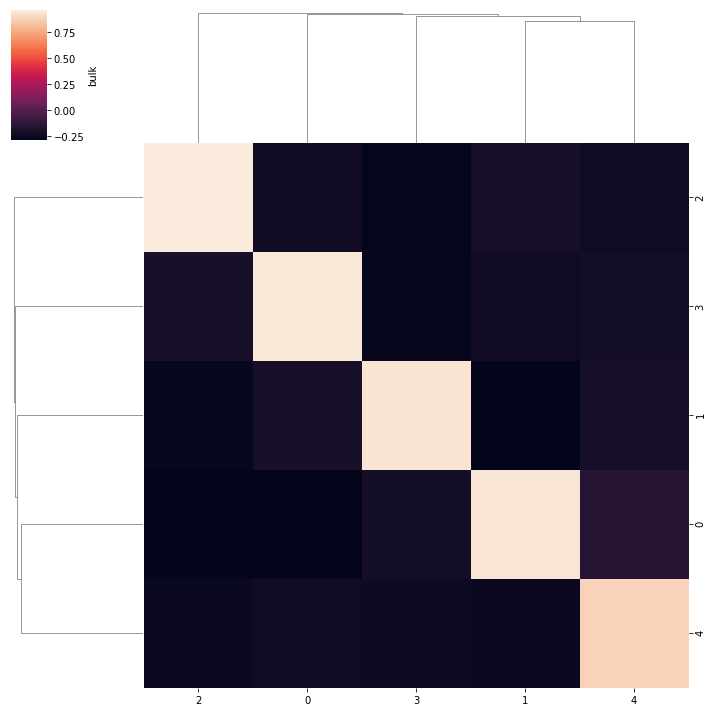

In [42]:
df_beta = pd.DataFrame(dcpmfmb.Ebeta)
df_w = pd.DataFrame(W.T)

corr=[]
for i in range(df_beta.shape[0]):
    cr = []
    for j in range(df_beta.shape[0]):
        cr.append(np.corrcoef(df_beta.iloc[i,:],df_w.iloc[j,:])[0,1])
    corr.append(cr)
sns.clustermap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

Text(218.45454545454544, 0.5, 'bulk')

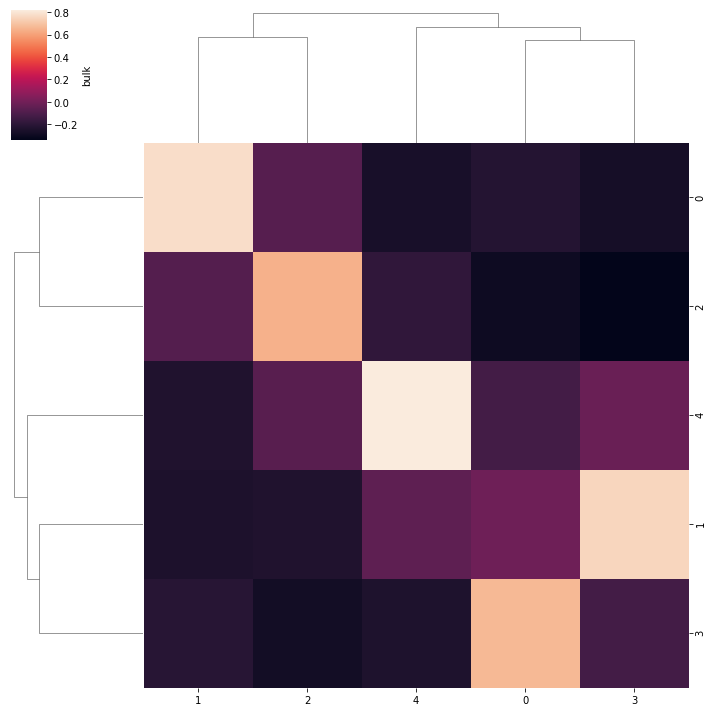

In [44]:
df_theta = pd.DataFrame(dcpmfmb.Etheta.T)
df_h = pd.DataFrame(H.T)

corr=[]
for i in range(df_theta.shape[0]):
    cr = []
    for j in range(df_theta.shape[0]):
        cr.append(np.corrcoef(df_theta.iloc[i,:],df_h.iloc[j,:])[0,1])
    corr.append(cr)
sns.clustermap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')